# Imperfect tests and respondent-driven sampling

For now, we consider the network dependence induced by the RDS with no
associated model. Therefore, we treat it as a random effect for
each individual. Conditionally autoregressive (CAR) models in the
Gaussian case are used. Let $[\tilde{Q}]_{ij} = \tilde{q}_{ij}$ be a fixed matrix which measures the distance between $i$
and $j$, and $\tilde{q}_{i+} = \sum_{j} \tilde{q}_{ij}$. In general, we use

$$
\tilde{q}_{ij} = \begin{cases}
  1, &\text{if } i \text{ recruited } j \text{ or the contrary} \\
  0, &\text{otherwise.} 
\end{cases}
$$

Next we define the scaled adjacency matrix $Q = D^{-1}\tilde{Q}$, such that $D$
is a diagonal matrix with $D_{ii} = \tilde{q}_{i+}$. Finally let $|\rho| < 1$ be a
parameter to controls the dependence between neighbors. Hence, we specify the
model as follows:

\begin{equation}
  \begin{aligned}
    T_i &\sim \operatorname{Bernoulli}(p_i) \\
    p_i &= \gamma_s\theta_i + (1-\gamma_e)(1 - \theta_i),  \\
    g(\theta_i) &= g(\theta) + \boldsymbol{x}_i^T\beta + \omega_i,  \\
    \omega_i|\{\omega_j\}_{j\neq i}, \tau &\sim \operatorname{Normal}\left(\rho\sum_j q_{ij}\omega_j, \tau^{-1}/\tilde{q}_{i+}\right) \\
    \beta &\sim \operatorname{Normal}(\mu, \Sigma), \\ 
    \theta &\sim \operatorname{Beta}(a^p, b^p) \\
    \gamma_s &\sim \operatorname{Beta}(a^s, b^s), \\
    \gamma_e &\sim \operatorname{Beta}(a^e, b^e), \\  
    \tau &\sim \operatorname{Gamma}(a^{\tau}, b^{\tau}).
  \end{aligned}  
\end{equation}

By Brook's Lemma {cite:t}`brook1964distinction`, the joint distribution of
$\omega$ can be specified as 

$$
\omega \sim \operatorname{Normal}\left(0, \left[\tau (D - \rho \tilde{Q})\right]^{-1}\right).
$$

In [27]:
import numpy as np
import pystan as ps
import stan_utility
from scipy.special import logit, expit
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle

import sys  
sys.path.insert(0, '../scripts/')

from artificial_data import GenerateData

## Notebook settings

In [28]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Stan model 

As usual, we can saved a compiled version for future experiments. 

In [41]:
#compiled = False
compiled = True

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_v5.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test_v5.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test_v5.pkl', 'wb') as f:
        pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d03c9865b540cd990e759264a2a431f3 NOW.


Below we can see the necessary information to the stan code. 

In [4]:
structure = sm.model_code.split('}')
print(structure[0] + '}' + structure[1]+'}') 

functions {
  /**
  * Return the log probability of a proper conditional autoregressive (CAR) prior 
  * with a sparse representation for the adjacency matrix
  *
  * @param omega Vector containing the parameters with a CAR prior
  * @param tau Precision parameter for the CAR prior (real)
  * @param rho Dependence (usually spatial) parameter for the CAR prior (real)
  * @param W_sparse Sparse representation of adjacency matrix (int array)
  * @param n Length of omega (int)
  * @param W_n Number of adjacent pairs (int)
  * @param D_sparse Number of neighbors for each location (vector)
  * @param lambda Eigenvalues of D^{-1/2}*W*D^{-1/2}


The parameters and transformed parameters of the model. 

In [5]:
print(structure[2] + '}' + structure[3] + '}' + structure[4] + '}') 

 (vector)
  *
  * @return Log probability density of CAR prior up to additive constant
  */
  real sparse_car_lpdf(vector omega, real rho, 
    int[,] W_sparse, vector D_sparse, vector lambda, int n, int W_n) {
      row_vector[n] omegat_D; // omega' * D
      row_vector[n] omegat_W; // omega' * W
      vector[n] ldet_terms;
    
      omegat_D = (omega .* D_sparse)';
      omegat_W = rep_row_vector(0, n);
      for (i in 1:W_n) {
        omegat_W[W_sparse[i, 1]] = omegat_W[W_sparse[i, 1]] + omega[W_sparse[i, 2]];
        omegat_W[W_sparse[i, 2]] = omegat_W[W_sparse[i, 2]] + omega[W_sparse[i, 1]];
      }
    
      for (i in 1:n) ldet_terms[i] = log1m(rho * lambda[i]);
      return 0.5 * (sum(ldet_terms) - omegat_D * omega + rho * (omegat_W * omega));
  }
  real gumbel_type2_lpdf(real tau, real lambda){
    return log(lambda) - 3/2 * log(tau) - lambda*tau^(-1/2) - log(2); 
  }


The model

In [6]:
print(structure[5] + '}' + structure[6] + '}') 


} 
data {
    int<lower=0> n_samples;
    int<lower=0> n_predictors; 
  
    int<lower=0, upper=1> Y[n_samples];
    matrix[n_samples, n_predictors] X;

    cov_matrix[n_predictors] Sigma; 
    vector[n_predictors] mu;
    real<lower = 0> alpha_p; 
    real<lower = 0> beta_p;
    real<lower = 0> alpha_s; 
    real<lower = 0> beta_s;
    real<lower = 0> alpha_e; 
    real<lower = 0> beta_e;
    real<lower = 0> alpha_tau; 
    real<lower = 0> beta_tau;
    
    matrix<lower = 0, upper = 1>[n_samples, n_samples] adj_matrix; 
    int adj_pairs;
}


## Simulated data

First we describe data created artificially as it was generated by this model.
It serves as a confirmation of functionality of the code. First we get the
data using the class `GenerateData()`. 

Note that we actually only need the adjacency matrix. In the following, we
will use to aggregate that to the entire data. 

In [7]:
def simulation(n_samples, rule, parameters_rule, rho, tau, RDS_R=0,
               prevalence=0.1, gamma_s=0.9, gamma_e=0.8, beta=np.array([-0.1, 2.5, 1.4, -1.8, 0.3]),
               n_pred_cont=3, n_pred_binary=2, seed=63289371):
    
    ro = np.random.RandomState(seed)
    
    gen_graph = GenerateData()
    graph = gen_graph.random_graph(rule=rule, 
                                   parameters=parameters_rule)
    rds_sample = gen_graph.RDS_generator(graph = graph, seed = 2000, 
                                         n_seeds = 10, sample_size = n_samples, 
                                         probs = [1/3,1/6,1/6,1/3], R=RDS_R)
        
    rds_sample.remove_nodes_from(list(nx.isolates(rds_sample)))
    A = nx.adjacency_matrix(rds_sample.to_undirected()).toarray()
    n_samples = rds_sample.number_of_nodes()
    D = np.diag(A.sum(axis = 1))
    
    n_predictors = n_pred_cont + n_pred_binary
    x = np.zeros((n_samples, n_predictors))
    x[:, :n_pred_cont] = ro.multivariate_normal(mean = np.zeros(n_pred_cont), 
                                                cov = np.eye(n_pred_cont),
                                                size = n_samples)
    x[:, :n_pred_cont] = 0.5 * (x[:, :n_pred_cont] - x[:, :n_pred_cont].mean(axis=0))/x[:, :n_pred_cont].std(axis = 0)
    x[:, n_pred_cont:] = ro.binomial(n = 1, p = [0.3, 0.7], size = (n_samples, n_pred_binary))
    if rule[-12:] == 'preferential':
        x[:, -1] = np.array([k[1]['binary'] for k in list(rds_sample.nodes.data())])
    
    omega = np.random.multivariate_normal(mean = np.zeros(n_samples), 
                                          cov = (1/tau)*np.linalg.inv(D - rho*A), 
                                          ).reshape(-1,1)
    x_effects = (x@beta).reshape(n_samples, 1)
    theta = expit(logit(prevalence) + x_effects + omega)
    p = 1-gamma_e + (gamma_e+gamma_s-1)*theta
    T = ro.binomial(n=1, p=p)
                          
    data = {
        "n_samples"    : n_samples,
        "n_predictors" : n_predictors,
        "Y"            : T.flatten(),
        "X"            : x,
        "adj_matrix"   : A, 
        "adj_pairs"    : int(A.sum()//2)
    } 
    
    return data, theta, p, rds_sample

In [31]:
data, _, _, _ = simulation(n_samples=300, 
                           rule='erdos-renyi', 
                           parameters_rule={'n': 10000, 'p': 0.005, 'seed': 397381297},
                           seed=397381297,
                           rho=0.9,
                           tau=1,
                           RDS_R=0)

In [44]:
# Hyperparameters of the model. 
data.update({    
    "Sigma"        : np.eye(5),
    "mu"           : np.zeros(5),
    "alpha_p"      : 2,
    "beta_p"       : 20,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    
    "tau_prior"    : 2, 
    "alpha_tau"    : 1, 
    "beta_tau"     : 1, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 9,
    "beta_rho"     : 1
})

In [49]:
%%time
fit_imperfect_rds = sm.sampling(data=data, warmup=5000, 
                                iter=6000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'))
summary = az.summary(fit_imperfect_rds)

CPU times: user 310 ms, sys: 64.4 ms, total: 374 ms
Wall time: 1min 53s


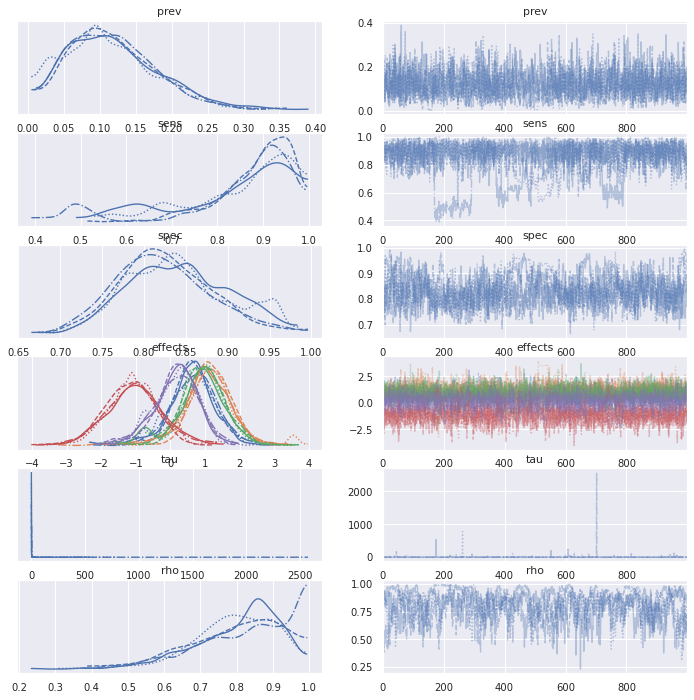

In [50]:
az.plot_trace(fit_imperfect_rds)
plt.show()

In [12]:
data, _, _, _ = simulation(n_samples=150, 
                           rule='erdos-renyi-preferential', 
                           parameters_rule={'n': 10000, 'p1': 0.008, 'p2': 0.004, 'p_z1': 0.3, 'seed': 397381297},
                           seed=397381297,
                           rho=0.9,
                           tau=1,
                           RDS_R=0.5)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
# Hyperparameters of the model. 
data.update({    
    "Sigma"        : np.eye(5),
    "mu"           : np.zeros(5),
    "alpha_p"      : 2,
    "beta_p"       : 20,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    "alpha_tau"    : 1, 
    "beta_tau"     : 1, 
})

In [14]:
%%time
fit_imperfect_rds = sm.sampling(data=data, iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'))
summary = az.summary(fit_imperfect_rds)

CPU times: user 260 ms, sys: 56.5 ms, total: 316 ms
Wall time: 14.4 s


In [15]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.145,0.069,0.024,0.267,0.001,0.001,5165.0,4433.0,1.00
sens,0.909,0.059,0.803,0.995,0.001,0.000,6727.0,4680.0,1.00
spec,0.778,0.067,0.661,0.913,0.002,0.002,932.0,689.0,1.00
effects[0],-0.598,0.731,-1.962,0.788,0.009,0.007,6730.0,5944.0,1.00
effects[1],1.282,0.803,-0.153,2.889,0.010,0.007,6022.0,5410.0,1.00
effects[2],-0.398,0.734,-1.812,0.962,0.009,0.008,6655.0,5335.0,1.00
effects[3],-0.812,0.709,-2.117,0.562,0.008,0.007,7311.0,5960.0,1.00
effects[4],-0.289,0.695,-1.628,0.981,0.011,0.008,4182.0,5342.0,1.00
tau,0.928,0.951,0.003,2.669,0.022,0.015,763.0,573.0,1.00
rho,0.476,0.285,0.006,0.937,0.015,0.012,354.0,366.0,1.02


In [16]:
data, _, _, _ = simulation(n_samples=150, 
                           rule='barabasi-albert', 
                           parameters_rule={'n': 10000, 'm': 25, 'seed': 397381297},
                           seed=397381297,
                           rho=0.9,
                           tau=1,
                           RDS_R=0)

In [17]:
# Hyperparameters of the model. 
data.update({    
    "Sigma"        : np.eye(5),
    "mu"           : np.zeros(5),
    "alpha_p"      : 2,
    "beta_p"       : 20,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    "alpha_tau"    : 1, 
    "beta_tau"     : 1, 
})

In [18]:
%%time
fit_imperfect_rds = sm.sampling(data=data, iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'))
summary = az.summary(fit_imperfect_rds)

CPU times: user 220 ms, sys: 39.9 ms, total: 260 ms
Wall time: 12.4 s


In [20]:
data, _, _, _ = simulation(n_samples=150, 
                           rule='barabasi-albert-preferential', 
                           parameters_rule={'n': 10000, 'm': 25, 'p': 0.5,'p_z1': 0.3, 'seed': 397381297},
                           seed=397381297,
                           rho=0.9,
                           tau=1,
                           RDS_R=0.5)

  0%|          | 0/9975 [00:00<?, ?it/s]

In [24]:
# Hyperparameters of the model. 
data.update({    
    "Sigma"        : np.eye(5),
    "mu"           : np.zeros(5),
    "alpha_p"      : 1/2,
    "beta_p"       : 1/2,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    "alpha_tau"    : 1, 
    "beta_tau"     : 1, 
})

In [25]:
%%time
fit_imperfect_rds = sm.sampling(data=data, iter=5000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'))
summary = az.summary(fit_imperfect_rds)

CPU times: user 215 ms, sys: 52.2 ms, total: 267 ms
Wall time: 7.89 s


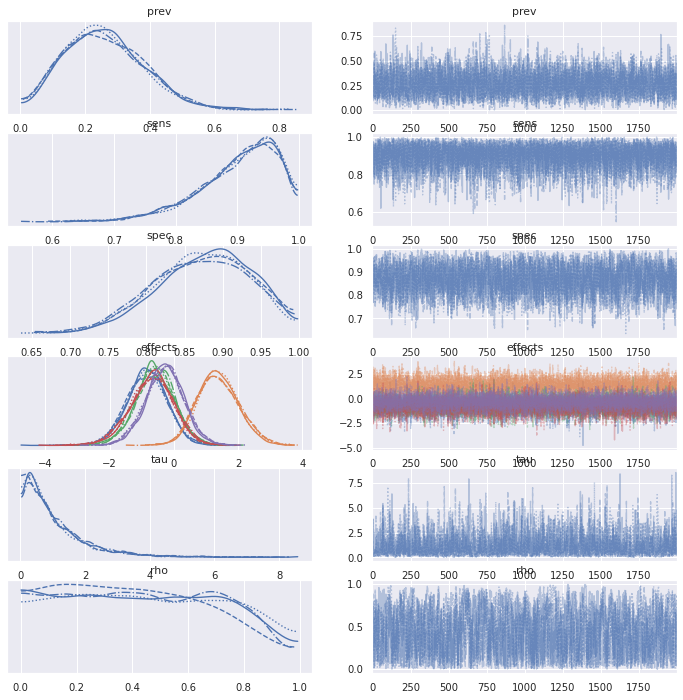

In [26]:
az.plot_trace(fit_imperfect_rds)
plt.show()